<a href="https://colab.research.google.com/github/maglili/ai_cup-mango-cnn_base/blob/main/nn_crop_imbalance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab

- 將 baseline 的下游從 svm 轉換為 nn。
- 訓練練資料的正負資料集不平衡。
- 圖片被裁切成數個小bbox

In [1]:
cd /content/drive/MyDrive/Projects/AI_CUP-Mango

/content/drive/MyDrive/Projects/AI_CUP-Mango


In [2]:
pwd

'/content/drive/MyDrive/Projects/AI_CUP-Mango'

# Preparing data

In [3]:
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import pickle 
import matplotlib.pylab as plt # plot module

from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn import metrics

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models

In [4]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('GPU is avalible.')
  print('Working on:', torch.cuda.get_device_name())
else:
  device = torch.device('cpu')
  print('GPU is not avalible.')
  print('Working on CPU')

GPU is avalible.
Working on: Tesla T4


In [5]:
with open('/content/drive/MyDrive/Projects/AI_CUP-Mango/C2_TrainDev/processed_data/baseline_crop/train_feature.pkl', 'rb') as f:
    train_feature = pickle.load(f)

with open('/content/drive/MyDrive/Projects/AI_CUP-Mango/C2_TrainDev/processed_data/baseline_crop/dev_feature.pkl', 'rb') as f:
    dev_feature = pickle.load(f)

In [6]:
print('len of train_feature:',len(train_feature))
print('len of dev_feature:',len(dev_feature))

len of train_feature: 43370
len of dev_feature: 6280


## Spliting 5 stacks

train data set

In [7]:
c0_pos = []
c0_neg = []
c1_pos = []
c1_neg = []
c2_pos = []
c2_neg = []
c3_pos = []
c3_neg = []
c4_pos = []
c4_neg = []

In [8]:
for img, label in train_feature:
    if label[0][0] == 1:
        c0_pos.append((img, 1))
    else:
        c0_neg.append((img, 0))
    
    if label[0][1] == 1:
        c1_pos.append((img, 1))
    else:
        c1_neg.append((img, 0))

    if label[0][2] == 1:
        c2_pos.append((img, 1))
    else:
        c2_neg.append((img, 0))
        
    if label[0][3] == 1:
        c3_pos.append((img, 1))
    else:
        c3_neg.append((img, 0))
        
    if label[0][4] == 1:
        c4_pos.append((img, 1))
    else:
        c4_neg.append((img, 0))

Dev data set

In [9]:
c0_pos_dev = []
c0_neg_dev = []
c1_pos_dev = []
c1_neg_dev = []
c2_pos_dev = []
c2_neg_dev = []
c3_pos_dev = []
c3_neg_dev = []
c4_pos_dev = []
c4_neg_dev = []

In [10]:
for img, label in dev_feature:
    if label[0][0] == 1:
        c0_pos_dev.append((img, 1))
    else:
        c0_neg_dev.append((img, 0))
    
    if label[0][1] == 1:
        c1_pos_dev.append((img, 1))
    else:
        c1_neg_dev.append((img, 0))

    if label[0][2] == 1:
        c2_pos_dev.append((img, 1))
    else:
        c2_neg_dev.append((img, 0))
        
    if label[0][3] == 1:
        c3_pos_dev.append((img, 1))
    else:
        c3_neg_dev.append((img, 0))
        
    if label[0][4] == 1:
        c4_pos_dev.append((img, 1))
    else:
        c4_neg_dev.append((img, 0))

In [11]:
print('Train:')
print('c0: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c0_pos), len(c0_neg), len(c0_pos)+len(c0_neg)))
print('c1: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c1_pos), len(c1_neg), len(c1_pos)+len(c1_neg)))
print('c2: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c2_pos), len(c2_neg), len(c2_pos)+len(c2_neg)))
print('c3: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c3_pos), len(c3_neg), len(c3_pos)+len(c3_neg)))
print('c4: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c4_pos), len(c4_neg), len(c4_pos)+len(c4_neg)))
print()

print('Dev:')
print('c0: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c0_pos_dev), len(c0_neg_dev), len(c0_pos_dev)+len(c0_neg_dev)))
print('c1: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c1_pos_dev), len(c1_neg_dev), len(c1_pos_dev)+len(c1_neg_dev)))
print('c2: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c2_pos_dev), len(c2_neg_dev), len(c2_pos_dev)+len(c2_neg_dev)))
print('c3: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c3_pos_dev), len(c3_neg_dev), len(c3_pos_dev)+len(c3_neg_dev)))
print('c4: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c4_pos_dev), len(c4_neg_dev), len(c4_pos_dev)+len(c4_neg_dev)))

Train:
c0: pos= 2579   neg= 40791  sum= 43370
c1: pos= 502    neg= 42868  sum= 43370
c2: pos= 23587  neg= 19783  sum= 43370
c3: pos= 15045  neg= 28325  sum= 43370
c4: pos= 1657   neg= 41713  sum= 43370

Dev:
c0: pos= 391    neg= 5889   sum= 6280 
c1: pos= 90     neg= 6190   sum= 6280 
c2: pos= 3504   neg= 2776   sum= 6280 
c3: pos= 1997   neg= 4283   sum= 6280 
c4: pos= 298    neg= 5982   sum= 6280 


## Combining pos and net data

In [13]:
def data_list(pos_list, neg_list):
    """
    把正負資料合併並打散後，輸出資料
    """
    pos = pos_list
    neg = neg_list
    output = pos + neg        
    output = shuffle(output, random_state=0)
    return output

In [14]:
c0 = data_list(c0_pos, c0_neg)
c1 = data_list(c1_pos, c1_neg)
c2 = data_list(c2_pos, c2_neg)
c3 = data_list(c3_pos, c3_neg)
c4 = data_list(c4_pos, c4_neg)

c0_dev = data_list(c0_pos_dev, c0_neg_dev)
c1_dev = data_list(c1_pos_dev, c1_neg_dev)
c2_dev = data_list(c2_pos_dev, c2_neg_dev)
c3_dev = data_list(c3_pos_dev, c3_neg_dev)
c4_dev = data_list(c4_pos_dev, c4_neg_dev)

## Check label balance

In [15]:
def check_balance(data):
    """
    檢查資料數量是否一致
    """
    pos=0
    neg=0
    for i,j in data:
        if j == 1:
            pos += 1
        else:
            neg += 1
    print('pos:',pos)
    print('neg:',neg)
    print('sum:',pos+neg)

In [16]:
print('Train:')
print()
for i in [c0, c1, c2, c3, c4]:
    check_balance(i)
    print('-'*10)

Train:

pos: 2579
neg: 40791
sum: 43370
----------
pos: 502
neg: 42868
sum: 43370
----------
pos: 23587
neg: 19783
sum: 43370
----------
pos: 15045
neg: 28325
sum: 43370
----------
pos: 1657
neg: 41713
sum: 43370
----------


In [17]:
print('Dev:')
print()
for i in [c0_dev, c1_dev, c2_dev, c3_dev, c4_dev]:
    check_balance(i)
    print('-'*10)

Dev:

pos: 391
neg: 5889
sum: 6280
----------
pos: 90
neg: 6190
sum: 6280
----------
pos: 3504
neg: 2776
sum: 6280
----------
pos: 1997
neg: 4283
sum: 6280
----------
pos: 298
neg: 5982
sum: 6280
----------


## Splitting features and labels

In [18]:
def split_x_y(data):
    """
    把資料中的 feature 跟 label 分離
    """
    X=[]
    y=[]
    for i,j in data:
        X.append(i)
        y.append(j)
    return X,y

In [19]:
c0_X, c0_y = split_x_y(c0)
c1_X, c1_y = split_x_y(c1)
c2_X, c2_y = split_x_y(c2)
c3_X, c3_y = split_x_y(c3)
c4_X, c4_y = split_x_y(c4)

In [20]:
c0_X_dev, c0_y_dev = split_x_y(c0_dev)
c1_X_dev, c1_y_dev = split_x_y(c1_dev)
c2_X_dev, c2_y_dev = split_x_y(c2_dev)
c3_X_dev, c3_y_dev = split_x_y(c3_dev)
c4_X_dev, c4_y_dev = split_x_y(c4_dev)

## Function for calc metrics

In [41]:
def calc_metrics(train=True):
    if train:
        (TP, FP, TN, FN) = useful_stuff['train_metric'][-1]
        print('[Train]Total sample: {}'.format(TP+FP+TN+FN))
    else:
        (TP, FP, TN, FN) = useful_stuff['valid_metric'][-1]
        print('[Dev]Total sample: {}'.format(TP+FP+TN+FN))

    acc = (TP + TN) / (TP + FP + TN + FN)

    recall = TP / (TP + FN) #召回率是在所有正樣本當中，能夠預測多少正樣本的比例
    specificity = TN / (TN + FP) #特異度是在所有負樣本當中，能夠預測多少負樣本的比例

    precision = TP / (TP + FP) #準確率為在所有預測為正樣本中，有多少為正樣本

    f1 = (2 * recall * precision ) / (recall + precision) #F1-score則是兩者的調和平均數
    mcc = ( TP*TN - FP*FN ) / np.sqrt( ((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) )

    print('TP:',TP)
    print('FP:',FP)
    print('TN:',TN)
    print('FN:',FN)
    print()
    print('acc:', acc)
    print('recall:', recall)
    print('specificity:', specificity)
    print('precision:', precision)
    print('f1:',f1)
    print('mcc:',mcc)

# class 0

## dataset

In [25]:
class Data(Dataset):
    def __init__(self, x_list, y_list):
        self.x_list = x_list
        self.y_list = y_list
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.x_list[idx][0])
        y = torch.tensor(self.y_list[idx])

        return x, y

    def __len__(self):
        return len(self.x_list)

In [26]:
train_set_c0 = Data(c0_X, c0_y)
dev_set_c0 = Data(c0_X_dev, c0_y_dev)

## model

### Prepare

In [73]:
 def train(model, train_loader, cv_loader, optimizer, N_train, N_test, epochs=20):
 
    useful_stuff = {'train_cost':[], 'train_acc':[], 'valid_cost':[], 'valid_acc':[], 'train_metric':[], 'valid_metric':[]} 

    for epoch in tqdm(range(epochs)):
        #training===========================================
        model.train() # Switch to train mode
        correct = 0
        training_loss=[]
        TP = FP = TN = FN = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            z = model(x)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y).sum().item()
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            training_loss.append(loss.data.item())

            # calu metric
            TP += ((yhat == 1) & (y == 1)).sum().item()
            FP += ((yhat == 1) & (y == 0)).sum().item()
            TN += ((yhat == 0) & (y == 0)).sum().item()
            FN += ((yhat == 0) & (y == 1)).sum().item()       

        useful_stuff['train_cost'].append(np.mean(training_loss))
        useful_stuff['train_acc'].append(correct / N_train)
        useful_stuff['train_metric'].append((TP, FP, TN, FN))

        print('[epoch {}]'.format(epoch))
        print('train_acc:',correct / N_train)
        print('train_loss:',np.mean(training_loss))
        print()

        #valid==================================================
        model.eval() # Switch to train mode
        correct = 0
        cv_loss=[]
        TP = FP = TN = FN = 0

        with torch.no_grad():
          for x_test, y_test in cv_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
            loss = criterion(z, y_test)         
            cv_loss.append(loss.data.item())

            # calu metric
            TP += ((yhat == 1) & (y_test == 1)).sum().item()
            FP += ((yhat == 1) & (y_test == 0)).sum().item()
            TN += ((yhat == 0) & (y_test == 0)).sum().item()
            FN += ((yhat == 0) & (y_test == 1)).sum().item() 

          useful_stuff['valid_cost'].append(np.mean(cv_loss))
          useful_stuff['valid_acc'].append(correct / N_test)
          useful_stuff['valid_metric'].append((TP, FP, TN, FN))

        print('train_acc:',correct / N_test)
        print('train_loss:',np.mean(np.mean(cv_loss)))
        print('='*10)

        scheduler.step(np.mean(cv_loss)) # learning rate scheduler <---------------------------------------------------------

    return useful_stuff

In [74]:
class Net(nn.Module):   
    # Constructor
    def __init__(self,neuron=100, p=0.1):
        super(Net, self).__init__()
        self.neuron=neuron
        self.drop=p

        self.step = nn.Sequential(
            nn.Linear(2000, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(self.neuron, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(self.neuron, 2),           
        )
    def forward(self, x):
        x = self.step(x)
        return x

### Hpyer parameters

In [75]:
model_c0 = Net(neuron=100, p=0.2)
model_c0.to(device);

N_train = len(train_set_c0)
N_test = len(dev_set_c0)

weights = [1.0, 15.82]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

learning_rate = 0.0005
optimizer = torch.optim.AdamW(model_c0.parameters(), lr=learning_rate, amsgrad=True)

train_loader = DataLoader(train_set_c0, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_set_c0, batch_size=64)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1) # learning rate decay

## training

In [76]:
useful_stuff = train(model=model_c0, train_loader=train_loader, cv_loader=dev_loader, N_train=N_train, N_test=N_test, optimizer=optimizer, epochs=20)

[epoch 0]
train_acc: 0.7906848051648605
train_loss: 0.5069794545505075

train_acc: 0.828343949044586
train_loss: 0.45889090844477065
[epoch 1]
train_acc: 0.8231035277841826
train_loss: 0.4592784795481547

train_acc: 0.8498407643312101
train_loss: 0.4147988500619175
[epoch 2]
train_acc: 0.8341480285911921
train_loss: 0.4370427578357996

train_acc: 0.8428343949044586
train_loss: 0.4279720027639408
[epoch 3]
train_acc: 0.8384367074014296
train_loss: 0.42213975676063414

train_acc: 0.8576433121019108
train_loss: 0.4083664956116917
[epoch 4]
train_acc: 0.8394973483975098
train_loss: 0.4160907743031648

train_acc: 0.8421974522292993
train_loss: 0.3925143636838354
[epoch 5]
train_acc: 0.8413419414341711
train_loss: 0.40705389283311755

train_acc: 0.8243630573248407
train_loss: 0.38725613448957
[epoch 6]
train_acc: 0.8488817154715241
train_loss: 0.3987472969434254

train_acc: 0.85
train_loss: 0.3986917698022091
[epoch 7]
train_acc: 0.8472676965644454
train_loss: 0.39061284224587906

train_acc:

## Learning Curve

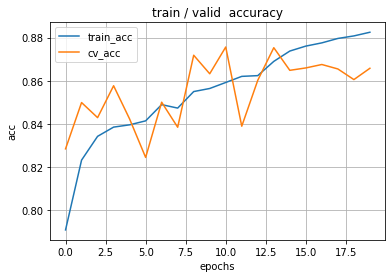

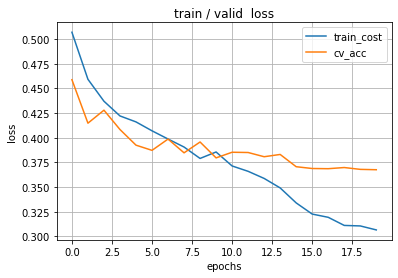

In [77]:
plt.plot(useful_stuff['train_acc'], label='train_acc')
plt.plot(useful_stuff['valid_acc'], label='cv_acc')
plt.title('train / valid  accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
#axes = plt.gca()
#axes.set_ylim([0.4, 1])
plt.legend()
plt.grid()
plt.show()

plt.plot(useful_stuff['train_cost'], label='train_cost')
plt.plot(useful_stuff['valid_cost'], label='cv_acc')
plt.title('train / valid  loss')
plt.xlabel('epochs')
plt.ylabel('loss')
#axes = plt.gca()
#axes.set_ylim([0, 1])
plt.legend()
plt.grid()
plt.show()

In [78]:
calc_metrics()
print('-'*20)
print()
calc_metrics(False)

[Train]Total sample: 43370
TP: 2215
FP: 4732
TN: 36059
FN: 364

acc: 0.882499423564676
recall: 0.8588600232648314
specificity: 0.8839940182883479
precision: 0.31884266589894916
f1: 0.46504304010077685
mcc: 0.47898821849918305
--------------------

[Dev]Total sample: 6280
TP: 315
FP: 767
TN: 5122
FN: 76

acc: 0.865764331210191
recall: 0.8056265984654731
specificity: 0.869757174392936
precision: 0.2911275415896488
f1: 0.42769857433808556
mcc: 0.4321435245629928


# class 1

## dataset

In [55]:
class Data(Dataset):
    def __init__(self, x_list, y_list):
        self.x_list = x_list
        self.y_list = y_list
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.x_list[idx][0])
        y = torch.tensor(self.y_list[idx])

        return x, y

    def __len__(self):
        return len(self.x_list)

In [56]:
train_set_c1 = Data(c1_X, c1_y)
dev_set_c1 = Data(c1_X_dev, c1_y_dev)

## model

### Prepare

In [57]:
 def train(model, train_loader, cv_loader, optimizer, N_train, N_test, epochs=20):
 
    useful_stuff = {'train_cost':[], 'train_acc':[], 'valid_cost':[], 'valid_acc':[], 'train_metric':[], 'valid_metric':[]} 

    for epoch in tqdm(range(epochs)):
        #training===========================================
        model.train() # Switch to train mode
        correct = 0
        training_loss=[]
        TP = FP = TN = FN = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            z = model(x)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y).sum().item()
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            training_loss.append(loss.data.item())

            # calu metric
            TP += ((yhat == 1) & (y == 1)).sum().item()
            FP += ((yhat == 1) & (y == 0)).sum().item()
            TN += ((yhat == 0) & (y == 0)).sum().item()
            FN += ((yhat == 0) & (y == 1)).sum().item()       

        useful_stuff['train_cost'].append(np.mean(training_loss))
        useful_stuff['train_acc'].append(correct / N_train)
        useful_stuff['train_metric'].append((TP, FP, TN, FN))

        print('[epoch {}]'.format(epoch))
        print('train_acc:',correct / N_train)
        print('train_loss:',np.mean(training_loss))
        print()

        #valid==================================================
        model.eval() # Switch to train mode
        correct = 0
        cv_loss=[]
        TP = FP = TN = FN = 0

        with torch.no_grad():
          for x_test, y_test in cv_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
            loss = criterion(z, y_test)         
            cv_loss.append(loss.data.item())

            # calu metric
            TP += ((yhat == 1) & (y_test == 1)).sum().item()
            FP += ((yhat == 1) & (y_test == 0)).sum().item()
            TN += ((yhat == 0) & (y_test == 0)).sum().item()
            FN += ((yhat == 0) & (y_test == 1)).sum().item() 

          useful_stuff['valid_cost'].append(np.mean(cv_loss))
          useful_stuff['valid_acc'].append(correct / N_test)
          useful_stuff['valid_metric'].append((TP, FP, TN, FN))

        print('train_acc:',correct / N_test)
        print('train_loss:',np.mean(np.mean(cv_loss)))
        print('='*10)

        scheduler.step(np.mean(cv_loss)) # learning rate scheduler <---------------------------------------------------------

    return useful_stuff

In [58]:
class Net(nn.Module):   
    # Constructor
    def __init__(self,neuron=100, p=0.1):
        super(Net, self).__init__()
        self.neuron=neuron
        self.drop=p

        self.step = nn.Sequential(
            nn.Linear(2000, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(self.neuron, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(self.neuron, 2),           
        )
    def forward(self, x):
        x = self.step(x)
        return x

### Hpyer parameters

In [69]:
model_c1 = Net(neuron=100, p=0.2)
model_c1.to(device);

N_train = len(train_set_c1)
N_test = len(dev_set_c1)

weights = [1.0, 85.39]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

learning_rate = 0.0005
optimizer = torch.optim.AdamW(model_c1.parameters(), lr=learning_rate, amsgrad=True)

train_loader = DataLoader(train_set_c1, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_set_c1, batch_size=64)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1) # learning rate decay

## training

In [70]:
useful_stuff = train(model=model_c1, train_loader=train_loader, cv_loader=dev_loader, N_train=N_train, N_test=N_test, optimizer=optimizer, epochs=20)

[epoch 0]
train_acc: 0.9413880562600876
train_loss: 0.4773673896065152

train_acc: 0.9296178343949044
train_loss: 0.6291167213760241
[epoch 1]
train_acc: 0.9304818999308277
train_loss: 0.4350581362151203

train_acc: 0.881687898089172
train_loss: 0.5871488331544279
[epoch 2]
train_acc: 0.9287525939589578
train_loss: 0.4009187326033031

train_acc: 0.9437898089171974
train_loss: 0.6278741070718477
[epoch 3]
train_acc: 0.9313811390362001
train_loss: 0.38632687797720455

train_acc: 0.9450636942675159
train_loss: 0.6003666011371998
[epoch 4]
train_acc: 0.9312197371454922
train_loss: 0.3674205827463561

train_acc: 0.9202229299363057
train_loss: 0.6369244253093546
[epoch 5]
train_acc: 0.9316578279916994
train_loss: 0.372729138583824

train_acc: 0.9184713375796179
train_loss: 0.629650325636671
[epoch 6]
train_acc: 0.9290062255014987
train_loss: 0.33606861783933323

train_acc: 0.9171974522292994
train_loss: 0.5926472812589972
[epoch 7]
train_acc: 0.9353239566520637
train_loss: 0.3186048856856724

## Learning Curve

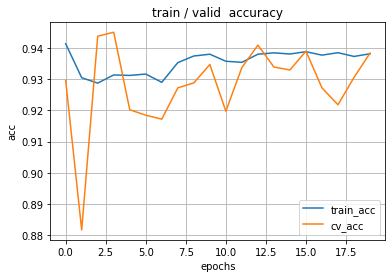

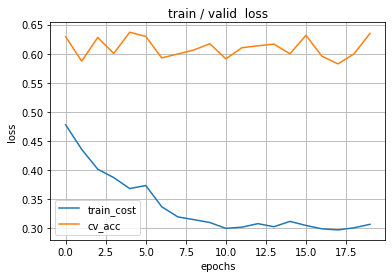

In [71]:
plt.plot(useful_stuff['train_acc'], label='train_acc')
plt.plot(useful_stuff['valid_acc'], label='cv_acc')
plt.title('train / valid  accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
#axes = plt.gca()
#axes.set_ylim([0.4, 1])
plt.legend()
plt.grid()
plt.show()

plt.plot(useful_stuff['train_cost'], label='train_cost')
plt.plot(useful_stuff['valid_cost'], label='cv_acc')
plt.title('train / valid  loss')
plt.xlabel('epochs')
plt.ylabel('loss')
#axes = plt.gca()
#axes.set_ylim([0, 1])
plt.legend()
plt.grid()
plt.show()

In [72]:
calc_metrics()
print('-'*20)
print()
calc_metrics(False)

[Train]Total sample: 43370
TP: 312
FP: 2492
TN: 40376
FN: 190

acc: 0.9381600184459303
recall: 0.6215139442231076
specificity: 0.9418680600914435
precision: 0.11126961483594865
f1: 0.18874773139745915
mcc: 0.24504810157524395
--------------------

[Dev]Total sample: 6280
TP: 33
FP: 330
TN: 5860
FN: 57

acc: 0.938375796178344
recall: 0.36666666666666664
specificity: 0.9466882067851373
precision: 0.09090909090909091
f1: 0.14569536423841062
mcc: 0.15958752356776681


# class 2

In [79]:
class Data(Dataset):
    def __init__(self, x_list, y_list):
        self.x_list = x_list
        self.y_list = y_list
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.x_list[idx][0])
        y = torch.tensor(self.y_list[idx])

        return x, y

    def __len__(self):
        return len(self.x_list)

In [80]:
train_set_c2 = Data(c2_X, c2_y)
dev_set_c2 = Data(c2_X_dev, c2_y_dev)

## model

### Prepare

In [83]:
 def train(model, train_loader, cv_loader, optimizer, N_train, N_test, epochs=20):
 
    useful_stuff = {'train_cost':[], 'train_acc':[], 'valid_cost':[], 'valid_acc':[], 'train_metric':[], 'valid_metric':[]} 

    for epoch in tqdm(range(epochs)):
        #training===========================================
        model.train() # Switch to train mode
        correct = 0
        training_loss=[]
        TP = FP = TN = FN = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            z = model(x)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y).sum().item()
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            training_loss.append(loss.data.item())

            # calu metric
            TP += ((yhat == 1) & (y == 1)).sum().item()
            FP += ((yhat == 1) & (y == 0)).sum().item()
            TN += ((yhat == 0) & (y == 0)).sum().item()
            FN += ((yhat == 0) & (y == 1)).sum().item()       

        useful_stuff['train_cost'].append(np.mean(training_loss))
        useful_stuff['train_acc'].append(correct / N_train)
        useful_stuff['train_metric'].append((TP, FP, TN, FN))

        print('[epoch {}]'.format(epoch))
        print('train_acc:',correct / N_train)
        print('train_loss:',np.mean(training_loss))
        print()

        #valid==================================================
        model.eval() # Switch to train mode
        correct = 0
        cv_loss=[]
        TP = FP = TN = FN = 0

        with torch.no_grad():
          for x_test, y_test in cv_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
            loss = criterion(z, y_test)         
            cv_loss.append(loss.data.item())

            # calu metric
            TP += ((yhat == 1) & (y_test == 1)).sum().item()
            FP += ((yhat == 1) & (y_test == 0)).sum().item()
            TN += ((yhat == 0) & (y_test == 0)).sum().item()
            FN += ((yhat == 0) & (y_test == 1)).sum().item() 

          useful_stuff['valid_cost'].append(np.mean(cv_loss))
          useful_stuff['valid_acc'].append(correct / N_test)
          useful_stuff['valid_metric'].append((TP, FP, TN, FN))

        print('train_acc:',correct / N_test)
        print('train_loss:',np.mean(np.mean(cv_loss)))
        print('='*10)

        scheduler.step(np.mean(cv_loss)) # learning rate scheduler <---------------------------------------------------------

    return useful_stuff

In [84]:
class Net(nn.Module):   
    # Constructor
    def __init__(self,neuron=100, p=0.1):
        super(Net, self).__init__()
        self.neuron=neuron
        self.drop=p

        self.step = nn.Sequential(
            nn.Linear(2000, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(self.neuron, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(self.neuron, 2),           
        )
    def forward(self, x):
        x = self.step(x)
        return x

### Hpyer parameters

In [85]:
model_c2 = Net(neuron=100, p=0.2)
model_c2.to(device);

N_train = len(train_set_c2)
N_test = len(dev_set_c2)

weights = [1.192, 1.0]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

learning_rate = 0.0005
optimizer = torch.optim.AdamW(model_c2.parameters(), lr=learning_rate, amsgrad=True)

train_loader = DataLoader(train_set_c2, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_set_c2, batch_size=64)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1) # learning rate decay

## training

In [86]:
useful_stuff = train(model=model_c2, train_loader=train_loader, cv_loader=dev_loader, N_train=N_train, N_test=N_test, optimizer=optimizer, epochs=20)

[epoch 0]
train_acc: 0.8622319575743601
train_loss: 0.3476854516880087

train_acc: 0.8834394904458599
train_loss: 0.3147687136825889
[epoch 1]
train_acc: 0.881023749135347
train_loss: 0.31398347850921937

train_acc: 0.8894904458598726
train_loss: 0.2994983455147406
[epoch 2]
train_acc: 0.8842748443624625
train_loss: 0.30272327905801016

train_acc: 0.881687898089172
train_loss: 0.3052602797144591
[epoch 3]
train_acc: 0.8872492506340789
train_loss: 0.29784175426119547

train_acc: 0.882484076433121
train_loss: 0.30408776423545797
[epoch 4]
train_acc: 0.8885865805856583
train_loss: 0.29319789930408857

train_acc: 0.884235668789809
train_loss: 0.30161886684822314
[epoch 5]
train_acc: 0.8896472215817385
train_loss: 0.28935317558876533

train_acc: 0.8949044585987261
train_loss: 0.2904454454629108
[epoch 6]
train_acc: 0.8929213742218123
train_loss: 0.2834942260136207

train_acc: 0.8904458598726115
train_loss: 0.29647566558736743
[epoch 7]
train_acc: 0.8943509338252248
train_loss: 0.28116865792

## Learning Curve

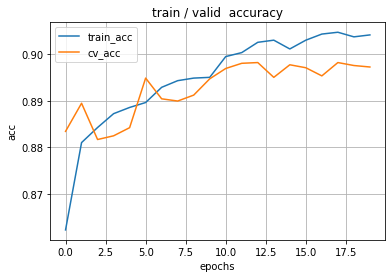

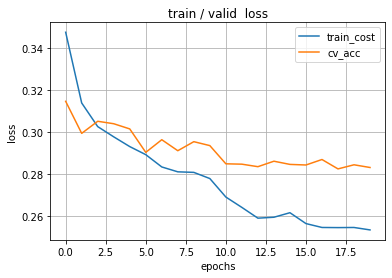

In [87]:
plt.plot(useful_stuff['train_acc'], label='train_acc')
plt.plot(useful_stuff['valid_acc'], label='cv_acc')
plt.title('train / valid  accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
#axes = plt.gca()
#axes.set_ylim([0.4, 1])
plt.legend()
plt.grid()
plt.show()

plt.plot(useful_stuff['train_cost'], label='train_cost')
plt.plot(useful_stuff['valid_cost'], label='cv_acc')
plt.title('train / valid  loss')
plt.xlabel('epochs')
plt.ylabel('loss')
#axes = plt.gca()
#axes.set_ylim([0, 1])
plt.legend()
plt.grid()
plt.show()

In [88]:
calc_metrics()
print('-'*20)
print()
calc_metrics(False)

[Train]Total sample: 43370
TP: 22399
FP: 2967
TN: 16816
FN: 1188

acc: 0.9041964491584045
recall: 0.9496332725653962
specificity: 0.8500227468028105
precision: 0.8830324055822755
f1: 0.9151226686822054
mcc: 0.8083047734767681
--------------------

[Dev]Total sample: 6280
TP: 3338
FP: 479
TN: 2297
FN: 166

acc: 0.8972929936305732
recall: 0.9526255707762558
specificity: 0.827449567723343
precision: 0.8745087765260676
f1: 0.9118972817921049
mcc: 0.7934780742283638


# class 3

## dataset

In [89]:
class Data(Dataset):
    def __init__(self, x_list, y_list):
        self.x_list = x_list
        self.y_list = y_list
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.x_list[idx][0])
        y = torch.tensor(self.y_list[idx])

        return x, y

    def __len__(self):
        return len(self.x_list)

In [90]:
train_set_c3 = Data(c3_X, c3_y)
dev_set_c3 = Data(c3_X_dev, c3_y_dev)

## model

### Prepare

In [91]:
 def train(model, train_loader, cv_loader, optimizer, N_train, N_test, epochs=20):
 
    useful_stuff = {'train_cost':[], 'train_acc':[], 'valid_cost':[], 'valid_acc':[], 'train_metric':[], 'valid_metric':[]} 

    for epoch in tqdm(range(epochs)):
        #training===========================================
        model.train() # Switch to train mode
        correct = 0
        training_loss=[]
        TP = FP = TN = FN = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            z = model(x)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y).sum().item()
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            training_loss.append(loss.data.item())

            # calu metric
            TP += ((yhat == 1) & (y == 1)).sum().item()
            FP += ((yhat == 1) & (y == 0)).sum().item()
            TN += ((yhat == 0) & (y == 0)).sum().item()
            FN += ((yhat == 0) & (y == 1)).sum().item()       

        useful_stuff['train_cost'].append(np.mean(training_loss))
        useful_stuff['train_acc'].append(correct / N_train)
        useful_stuff['train_metric'].append((TP, FP, TN, FN))

        print('[epoch {}]'.format(epoch))
        print('train_acc:',correct / N_train)
        print('train_loss:',np.mean(training_loss))
        print()

        #valid==================================================
        model.eval() # Switch to train mode
        correct = 0
        cv_loss=[]
        TP = FP = TN = FN = 0

        with torch.no_grad():
          for x_test, y_test in cv_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
            loss = criterion(z, y_test)         
            cv_loss.append(loss.data.item())

            # calu metric
            TP += ((yhat == 1) & (y_test == 1)).sum().item()
            FP += ((yhat == 1) & (y_test == 0)).sum().item()
            TN += ((yhat == 0) & (y_test == 0)).sum().item()
            FN += ((yhat == 0) & (y_test == 1)).sum().item() 

          useful_stuff['valid_cost'].append(np.mean(cv_loss))
          useful_stuff['valid_acc'].append(correct / N_test)
          useful_stuff['valid_metric'].append((TP, FP, TN, FN))

        print('train_acc:',correct / N_test)
        print('train_loss:',np.mean(np.mean(cv_loss)))
        print('='*10)

        scheduler.step(np.mean(cv_loss)) # learning rate scheduler <---------------------------------------------------------

    return useful_stuff

In [92]:
class Net(nn.Module):   
    # Constructor
    def __init__(self,neuron=100, p=0.1):
        super(Net, self).__init__()
        self.neuron=neuron
        self.drop=p

        self.step = nn.Sequential(
            nn.Linear(2000, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(self.neuron, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(self.neuron, 2),           
        )
    def forward(self, x):
        x = self.step(x)
        return x

### Hpyer parameters

In [93]:
model_c3 = Net(neuron=100, p=0.2)
model_c3.to(device);

N_train = len(train_set_c3)
N_test = len(dev_set_c3)

weights = [1, 1.882]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

learning_rate = 0.0005
optimizer = torch.optim.AdamW(model_c3.parameters(), lr=learning_rate, amsgrad=True)

train_loader = DataLoader(train_set_c3, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_set_c3, batch_size=64)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1) # learning rate decay

## training

In [94]:
useful_stuff = train(model=model_c3, train_loader=train_loader, cv_loader=dev_loader, N_train=N_train, N_test=N_test, optimizer=optimizer, epochs=20)

[epoch 0]
train_acc: 0.9133502421028361
train_loss: 0.2160763675841478

train_acc: 0.939968152866242
train_loss: 0.14000962480827414
[epoch 1]
train_acc: 0.9298362923679964
train_loss: 0.1763341854543461

train_acc: 0.9484076433121019
train_loss: 0.12567349875138867
[epoch 2]
train_acc: 0.935877334563062
train_loss: 0.16498883468151138

train_acc: 0.9471337579617835
train_loss: 0.12259483205700161
[epoch 3]
train_acc: 0.9371916071016831
train_loss: 0.15985901034670638

train_acc: 0.9512738853503184
train_loss: 0.12467466052057165
[epoch 4]
train_acc: 0.9398201521789256
train_loss: 0.15148927244305566

train_acc: 0.9453821656050956
train_loss: 0.11862994549852429
[epoch 5]
train_acc: 0.9419183767581277
train_loss: 0.14576782073460212

train_acc: 0.9514331210191083
train_loss: 0.1169097593261136
[epoch 6]
train_acc: 0.9421489508877104
train_loss: 0.14642323748549244

train_acc: 0.9401273885350319
train_loss: 0.12408068341513474
[epoch 7]
train_acc: 0.944800553377911
train_loss: 0.1417170

## Learning Curve

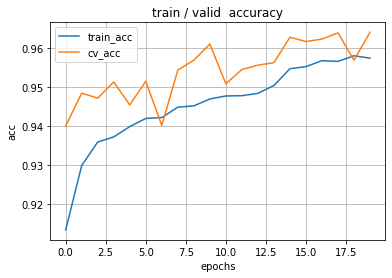

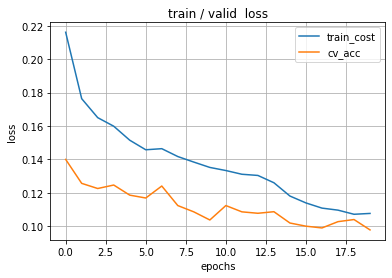

In [95]:
plt.plot(useful_stuff['train_acc'], label='train_acc')
plt.plot(useful_stuff['valid_acc'], label='cv_acc')
plt.title('train / valid  accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
#axes = plt.gca()
#axes.set_ylim([0.4, 1])
plt.legend()
plt.grid()
plt.show()

plt.plot(useful_stuff['train_cost'], label='train_cost')
plt.plot(useful_stuff['valid_cost'], label='cv_acc')
plt.title('train / valid  loss')
plt.xlabel('epochs')
plt.ylabel('loss')
#axes = plt.gca()
#axes.set_ylim([0, 1])
plt.legend()
plt.grid()
plt.show()

In [96]:
calc_metrics()
print('-'*20)
print()
calc_metrics(False)

[Train]Total sample: 43370
TP: 14486
FP: 1290
TN: 27035
FN: 559

acc: 0.957366843440166
recall: 0.9628447989365237
specificity: 0.9544571932921447
precision: 0.9182302231237323
f1: 0.9400084358067552
mcc: 0.9075856347319448
--------------------

[Dev]Total sample: 6280
TP: 1916
FP: 145
TN: 4138
FN: 81

acc: 0.9640127388535031
recall: 0.9594391587381071
specificity: 0.9661452253093626
precision: 0.9296458030082484
f1: 0.9443075406604239
mcc: 0.9179844611064691


# class 4

## dataset

In [97]:
class Data(Dataset):
    def __init__(self, x_list, y_list):
        self.x_list = x_list
        self.y_list = y_list
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.x_list[idx][0])
        y = torch.tensor(self.y_list[idx])

        return x, y

    def __len__(self):
        return len(self.x_list)

In [98]:
train_set_c4 = Data(c4_X, c4_y)
dev_set_c4 = Data(c4_X_dev, c4_y_dev)

## model

### Prepare

In [99]:
 def train(model, train_loader, cv_loader, optimizer, N_train, N_test, epochs=20):
 
    useful_stuff = {'train_cost':[], 'train_acc':[], 'valid_cost':[], 'valid_acc':[], 'train_metric':[], 'valid_metric':[]} 

    for epoch in tqdm(range(epochs)):
        #training===========================================
        model.train() # Switch to train mode
        correct = 0
        training_loss=[]
        TP = FP = TN = FN = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            z = model(x)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y).sum().item()
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            training_loss.append(loss.data.item())

            # calu metric
            TP += ((yhat == 1) & (y == 1)).sum().item()
            FP += ((yhat == 1) & (y == 0)).sum().item()
            TN += ((yhat == 0) & (y == 0)).sum().item()
            FN += ((yhat == 0) & (y == 1)).sum().item()       

        useful_stuff['train_cost'].append(np.mean(training_loss))
        useful_stuff['train_acc'].append(correct / N_train)
        useful_stuff['train_metric'].append((TP, FP, TN, FN))

        print('[epoch {}]'.format(epoch))
        print('train_acc:',correct / N_train)
        print('train_loss:',np.mean(training_loss))
        print()

        #valid==================================================
        model.eval() # Switch to train mode
        correct = 0
        cv_loss=[]
        TP = FP = TN = FN = 0

        with torch.no_grad():
          for x_test, y_test in cv_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
            loss = criterion(z, y_test)         
            cv_loss.append(loss.data.item())

            # calu metric
            TP += ((yhat == 1) & (y_test == 1)).sum().item()
            FP += ((yhat == 1) & (y_test == 0)).sum().item()
            TN += ((yhat == 0) & (y_test == 0)).sum().item()
            FN += ((yhat == 0) & (y_test == 1)).sum().item() 

          useful_stuff['valid_cost'].append(np.mean(cv_loss))
          useful_stuff['valid_acc'].append(correct / N_test)
          useful_stuff['valid_metric'].append((TP, FP, TN, FN))

        print('train_acc:',correct / N_test)
        print('train_loss:',np.mean(np.mean(cv_loss)))
        print('='*10)

        scheduler.step(np.mean(cv_loss)) # learning rate scheduler <---------------------------------------------------------

    return useful_stuff

In [100]:
class Net(nn.Module):   
    # Constructor
    def __init__(self,neuron=100, p=0.1):
        super(Net, self).__init__()
        self.neuron=neuron
        self.drop=p

        self.step = nn.Sequential(
            nn.Linear(2000, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(self.neuron, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(self.neuron, 2),           
        )
    def forward(self, x):
        x = self.step(x)
        return x

### Hpyer parameters

In [101]:
model_c4 = Net(neuron=100, p=0.2)
model_c4.to(device);

N_train = len(train_set_c4)
N_test = len(dev_set_c4)

weights = [1, 25.17]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

learning_rate = 0.0005
optimizer = torch.optim.AdamW(model_c4.parameters(), lr=learning_rate, amsgrad=True)

train_loader = DataLoader(train_set_c4, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_set_c4, batch_size=64)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1) # learning rate decay

## training

In [102]:
useful_stuff = train(model=model_c4, train_loader=train_loader, cv_loader=dev_loader, N_train=N_train, N_test=N_test, optimizer=optimizer, epochs=20)

[epoch 0]
train_acc: 0.7367535162554761
train_loss: 0.5500034077373226

train_acc: 0.7337579617834394
train_loss: 0.5499578326037435
[epoch 1]
train_acc: 0.745238644224118
train_loss: 0.5219023730441005

train_acc: 0.6754777070063694
train_loss: 0.537934939066569
[epoch 2]
train_acc: 0.7400046114825917
train_loss: 0.5023989982265639

train_acc: 0.7328025477707006
train_loss: 0.5336866824313847
[epoch 3]
train_acc: 0.7524325570670971
train_loss: 0.48197702873377324

train_acc: 0.7017515923566879
train_loss: 0.55989828269289
[epoch 4]
train_acc: 0.7530781646299285
train_loss: 0.48679212041221187

train_acc: 0.7308917197452229
train_loss: 0.547485608494643
[epoch 5]
train_acc: 0.7617938667281531
train_loss: 0.47941517203518774

train_acc: 0.6821656050955414
train_loss: 0.5172131458918253
[epoch 6]
train_acc: 0.758058565828914
train_loss: 0.47595719839267675

train_acc: 0.7203821656050955
train_loss: 0.5151142487020204
[epoch 7]
train_acc: 0.7632925985704404
train_loss: 0.47087297122650795

## Learning Curve

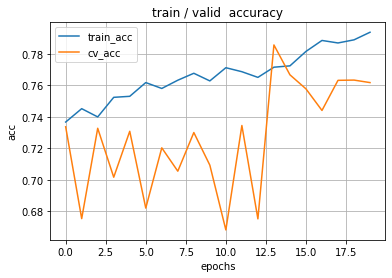

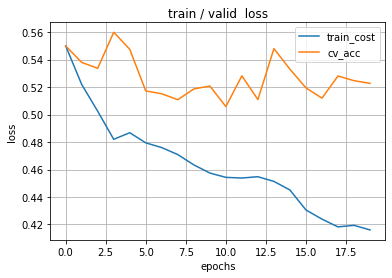

In [103]:
plt.plot(useful_stuff['train_acc'], label='train_acc')
plt.plot(useful_stuff['valid_acc'], label='cv_acc')
plt.title('train / valid  accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
#axes = plt.gca()
#axes.set_ylim([0.4, 1])
plt.legend()
plt.grid()
plt.show()

plt.plot(useful_stuff['train_cost'], label='train_cost')
plt.plot(useful_stuff['valid_cost'], label='cv_acc')
plt.title('train / valid  loss')
plt.xlabel('epochs')
plt.ylabel('loss')
#axes = plt.gca()
#axes.set_ylim([0, 1])
plt.legend()
plt.grid()
plt.show()

In [104]:
calc_metrics()
print('-'*20)
print()
calc_metrics(False)

[Train]Total sample: 43370
TP: 1290
FP: 8579
TN: 33134
FN: 367

acc: 0.7937283836753516
recall: 0.7785153892576946
specificity: 0.7943327020353367
precision: 0.13071233154321613
f1: 0.2238417490890161
mcc: 0.26192139636046863
--------------------

[Dev]Total sample: 6280
TP: 213
FP: 1411
TN: 4571
FN: 85

acc: 0.7617834394904459
recall: 0.714765100671141
specificity: 0.7641257104647275
precision: 0.1311576354679803
f1: 0.22164412070759623
mcc: 0.23252429809621114


# Saving model

In [113]:
# torch.save(model_c0, './C2_TrainDev/model/nn-crop-imbalance/model_c0.pt')
# torch.save(model_c1, './C2_TrainDev/model/nn-crop-imbalance/model_c1.pt')
# torch.save(model_c2, './C2_TrainDev/model/nn-crop-imbalance/model_c2.pt')
# torch.save(model_c3, './C2_TrainDev/model/nn-crop-imbalance/model_c3.pt')
# torch.save(model_c4, './C2_TrainDev/model/nn-crop-imbalance/model_c4.pt')